<a href="https://colab.research.google.com/github/enakai00/rl_book_solutions/blob/master/Chapter04/Exercise_4_7_(Policy_Iteration)_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.stats import poisson

from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

In [0]:
class CarRental:
  def __init__(self, size=20, gamma=0.9,
               fst_rent_mean=3, snd_rent_mean=4,
               fst_ret_mean=3, snd_ret_mean=2):
    self.size = size
    self.fst_rent_mean = fst_rent_mean
    self.snd_rent_mean = snd_rent_mean    
    self.fst_ret_mean = fst_ret_mean
    self.snd_ret_mean = snd_ret_mean       
    self.gamma = gamma

    self.states = [(fst, snd) for fst in range(size+1) for snd in range(size+1)]
    self.value = {}
    self.policy = {} # Greedy policy
    
    # Initialize with 0 values
    for s in self.states:
      self.value[s] = 0
      
    # Initialize with policy of moving no cars
    for s in self.states:
      self.policy[s] = 0
      
  def show_value(self):
    value = np.zeros((self.size+1, self.size+1))
    for s in self.states:
      (fst, snd) = s
      value[fst][snd] = self.value[s] # (x, y) = (snd, fst)

    x = range(0, self.size+1)
    y = range(0, self.size+1)
    X, Y = np.meshgrid(x, y)
    Z = value[Y, X]
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_wireframe(X, Y, Z, color='gray')
    ax.set_xticks(range(0, self.size+1, 4))
    ax.set_yticks(range(0, self.size+1, 4))
    ax.set_xlabel('second')
    ax.set_ylabel('first')
    ax.set_zlabel('value')

  def show_policy(self):
    result = np.zeros((self.size+1, self.size+1))
    for s in self.states:
      (fst, snd) = s
      result[fst][snd] = self.policy[s] # (x, y) = (snd, fst)
    sns.heatmap(result, cbar=False, annot=True, cmap='coolwarm')

In [0]:
def memoize(f):
  cache = {}
  def helper(*args):
    if args not in cache:
      cache[args] = f(*args)
    return cache[args]
  return helper

@memoize
def _poisson_pmf(n, mean):
  return poisson.pmf(n, mean)
  
@memoize
def poisson_pmf(n, n_max, mean):
  if n > n_max:
    return 0
  if n == n_max:
    return 1-sum([poisson.pmf(n, mean) for n in range(n_max)])
  return _poisson_pmf(n, mean)

In [0]:
def action_value_update(car_rental, s, a):
  size = car_rental.size
  fst_rent_mean = car_rental.fst_rent_mean
  snd_rent_mean = car_rental.snd_rent_mean    
  fst_ret_mean = car_rental.fst_ret_mean
  snd_ret_mean = car_rental.snd_ret_mean  
  gamma = car_rental.gamma
  
  (fst, snd) = s
  fst -= a # Moving cars
  snd += a # Moving cars

  r_base = 0
  # One car can be moved from fst to snd for free
  if a > 0:
    r_base += -2 * abs(a-1)
  else:
    r_base += -2 * abs(a)
  # Additional parking lot fee.
  if fst > 10:
    r_base += -4
  if snd > 10:
    r_base += -4
          
  q_new = 0
  # Loop for possible next states
  for fst_rent in range(fst+1):
    # Prob for fst_rent
    prob1 = poisson_pmf(fst_rent, fst, fst_rent_mean)
        
    for snd_rent in range(snd+1):
      # Prob for fst_rent * snd_rent
      prob2 = prob1 * poisson_pmf(snd_rent, snd, snd_rent_mean)
      # Reward for renting cars
      r = r_base + 10 * (fst_rent + snd_rent)

      for fst_ret in range(size-(fst-fst_rent)+1):
        # Prob for fst_rent * snd_rent * fst_ret
        prob3 = prob2 * poisson_pmf(fst_ret, size-(fst-fst_rent), fst_ret_mean)
         
        for snd_ret in range(size-(snd-snd_rent)+1):
          # Prob for fst_rent * snd_rent * fst_ret * snd_ret
          prob = prob3 * poisson_pmf(snd_ret, size-(snd-snd_rent), snd_ret_mean)

          s_new = (fst - fst_rent + fst_ret,
                   snd - snd_rent + snd_ret)
          q_new += prob * (r + gamma*car_rental.value[s_new])

  return q_new

In [0]:
def policy_eval(car_rental, theta=0.1):
  c = 0
  while True:
    deltas = []
    for s in car_rental.states:
      a = car_rental.policy[s]
      v = car_rental.value[s]
      v_new = action_value_update(car_rental, s, a)
      car_rental.value[s] = v_new
      deltas.append(abs(v-v_new))

    c += 1
    print ('End of iteration {}, delta={}'.format(c, max(deltas)))
    if max(deltas) < theta:
      break

In [0]:
def policy_update(car_rental):
  for s in car_rental.states:      
    # Search for argmax
    q = {}
    (_fst, _snd)  = s
    for a in range(-min(_snd, 5), min(_fst, 5)+1):
      q[a] = action_value_update(car_rental, s, a)

    car_rental.policy[s] = max(q, key=q.get)

In [0]:
car_rental = CarRental(size=20)

## 1st iteration

End of iteration 1, delta=172.6082577767952
End of iteration 2, delta=120.86733148490288
End of iteration 3, delta=82.7786042752544
End of iteration 4, delta=65.22547685589669
End of iteration 5, delta=52.09847374028459
End of iteration 6, delta=40.67176264259314
End of iteration 7, delta=31.886204556592304
End of iteration 8, delta=25.374602660822802
End of iteration 9, delta=21.20574019168879
End of iteration 10, delta=17.771298390603306
End of iteration 11, delta=14.861553487198876
End of iteration 12, delta=12.403819655872155
End of iteration 13, delta=10.333289606925632
End of iteration 14, delta=8.593402492768917
End of iteration 15, delta=7.135038068973813
End of iteration 16, delta=5.915602723504946
End of iteration 17, delta=4.898251315060406
End of iteration 18, delta=4.051234936913886
End of iteration 19, delta=3.3473266217064293
End of iteration 20, delta=2.763294616850146
End of iteration 21, delta=2.2794121767853994
End of iteration 22, delta=1.8790031687647684
End of ite

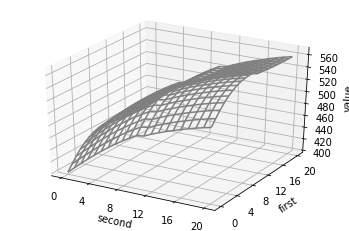

In [8]:
%%time
policy_eval(car_rental)
car_rental.show_value()

CPU times: user 1min 39s, sys: 167 ms, total: 1min 39s
Wall time: 1min 39s


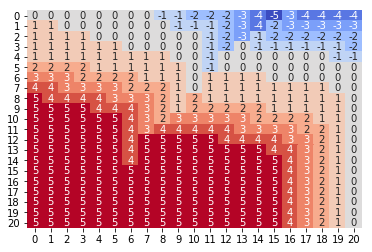

In [9]:
%%time
policy_update(car_rental)
car_rental.show_policy()

## 2nd iteration

End of iteration 1, delta=89.18535186686813
End of iteration 2, delta=9.114772205586405
End of iteration 3, delta=4.81968450089073
End of iteration 4, delta=3.434990118686642
End of iteration 5, delta=2.879611729454041
End of iteration 6, delta=2.3873354540251057
End of iteration 7, delta=1.962830614771974
End of iteration 8, delta=1.6095915653179418
End of iteration 9, delta=1.3183927873768084
End of iteration 10, delta=1.0792042813533271
End of iteration 11, delta=0.8830989913764711
End of iteration 12, delta=0.7224805620955408
End of iteration 13, delta=0.59100330003605
End of iteration 14, delta=0.4834162102257551
End of iteration 15, delta=0.39539598541995247
End of iteration 16, delta=0.3233928714865897
End of iteration 17, delta=0.26449676649269804
End of iteration 18, delta=0.2163241143759933
End of iteration 19, delta=0.17692369664740681
End of iteration 20, delta=0.14469875076343897
End of iteration 21, delta=0.11834285659932675
End of iteration 22, delta=0.09678728722320784


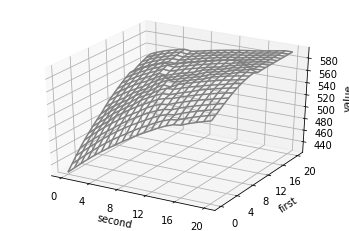

In [10]:
%%time
policy_eval(car_rental)
car_rental.show_value()

CPU times: user 2min 13s, sys: 146 ms, total: 2min 13s
Wall time: 2min 13s


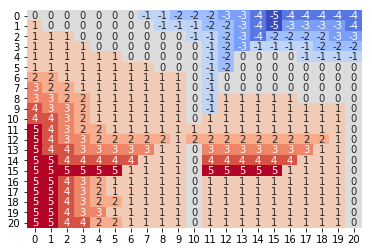

In [11]:
%%time
policy_update(car_rental)
car_rental.show_policy()

## 3rd iteration

End of iteration 1, delta=11.76703011238942
End of iteration 2, delta=5.971536560811614
End of iteration 3, delta=2.961995912912016
End of iteration 4, delta=1.5859579257971745
End of iteration 5, delta=1.0148763675615555
End of iteration 6, delta=0.7050160958270908
End of iteration 7, delta=0.5140802463515683
End of iteration 8, delta=0.3825674805837025
End of iteration 9, delta=0.2923081178198572
End of iteration 10, delta=0.22864937325198298
End of iteration 11, delta=0.18782336689207568
End of iteration 12, delta=0.15399851977150547
End of iteration 13, delta=0.12612323976583184
End of iteration 14, delta=0.10322283622366513
End of iteration 15, delta=0.08444468917622316
CPU times: user 3min 30s, sys: 29 ms, total: 3min 31s
Wall time: 3min 31s


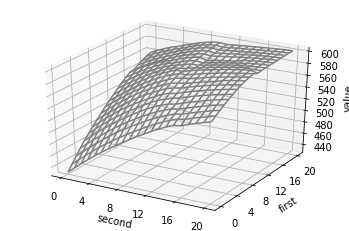

In [12]:
%%time
policy_eval(car_rental)
car_rental.show_value()

CPU times: user 2min 11s, sys: 136 ms, total: 2min 12s
Wall time: 2min 11s


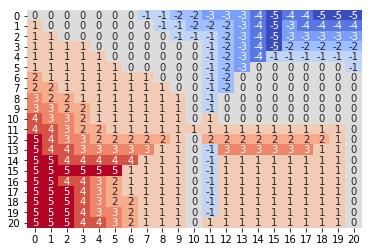

In [13]:
%%time
policy_update(car_rental)
car_rental.show_policy()

## 4th iteration

End of iteration 1, delta=3.3677209805455277
End of iteration 2, delta=0.41583180920258656
End of iteration 3, delta=0.19461100709213497
End of iteration 4, delta=0.1254887578160151
End of iteration 5, delta=0.08190224390978074
CPU times: user 1min 11s, sys: 21 ms, total: 1min 11s
Wall time: 1min 11s


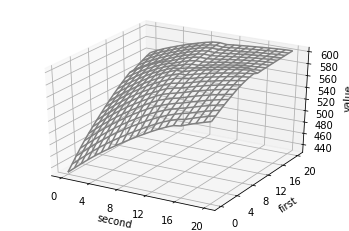

In [14]:
%%time
policy_eval(car_rental)
car_rental.show_value()

CPU times: user 2min 11s, sys: 142 ms, total: 2min 11s
Wall time: 2min 11s


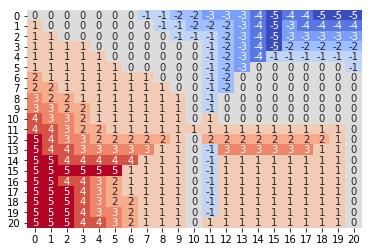

In [15]:
%%time
policy_update(car_rental)
car_rental.show_policy()

## 5th iteration

End of iteration 1, delta=0.05418130775910868
CPU times: user 14.4 s, sys: 11 ms, total: 14.4 s
Wall time: 14.4 s


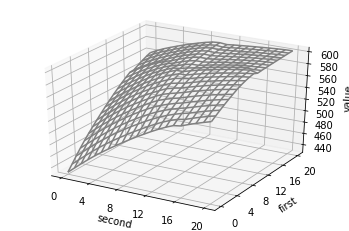

In [16]:
%%time
policy_eval(car_rental)
car_rental.show_value()

CPU times: user 2min 14s, sys: 138 ms, total: 2min 15s
Wall time: 2min 14s


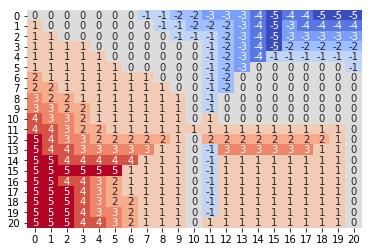

In [17]:
%%time
policy_update(car_rental)
car_rental.show_policy()